## Imports

In [1]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro.infer import MCMC, NUTS
# jax on M1: https://github.com/google/jax/issues/5501

# relative imports
import os
os.chdir('/Users/martinmarek/Google Drive/UCL/STAT0035/bnn-regression')
import models, distributions
from training.hmc import hmc_sampler
from training.nuts import nuts
from training.rwmh import rwmh_sampler
from training.sgd import train_sgd

/Users/martinmarek/miniforge3/envs/py39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [13]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
%load_ext autoreload
%autoreload 2

## Define target distribution

In [66]:
# define target distribution
d = 100
r = 0.9 # corellation
mean = jnp.zeros(d) # mean
cov = r*jnp.ones([d, d]) # covariances
cov = cov.at[jnp.diag_indices(d)].set(1) # variances
def target_log_pdf(x):
    return jax.scipy.stats.multivariate_normal.logpdf(x, mean, cov).sum()

## Sample values

In [87]:
# initial params
n_steps = 500
key = jax.random.PRNGKey(0)
params_init = jnp.zeros(d)

In [88]:
direct_samples = jax.random.multivariate_normal(key, mean, cov, [n_steps])

In [89]:
%%time
chain_rwmh = jnp.stack(rwmh_sampler(params_init, target_log_pdf, key, n_steps=n_steps, n_blind_steps=1000, step_size=0.1))

Avg. accept. prob.: 11.87%
CPU times: user 3.03 s, sys: 21.6 ms, total: 3.05 s
Wall time: 3.06 s


In [90]:
%%time
chain_hmc = jnp.stack(hmc_sampler(params_init, target_log_pdf, n_steps=n_steps, n_leapfrog_steps=100, step_size=0.1, key=key))

Avg. accept. prob.: 96.40%
CPU times: user 1.38 s, sys: 8.67 ms, total: 1.38 s
Wall time: 1.38 s


In [98]:
%%time
chain_nuts = jnp.stack(nuts(params_init, target_log_pdf, step_size=1e-5, key=key, n_steps=n_steps))

16384.00 steps, 100.00% valid, 100.00% acceptance.
Termination: max_steps=500, u-turn=0, max_error=0.
CPU times: user 1min 42s, sys: 335 ms, total: 1min 42s
Wall time: 1min 42s


In [95]:
%%time
potential_fn = lambda x: -target_log_pdf(x)
nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=n_steps)
mcmc.run(key, init_params=params_init)
chain_numpyro = mcmc.get_samples()

sample: 100%|█| 1500/1500 [00:01<00:00, 924.85it/s, 7 steps of size 1.75e-01. 

CPU times: user 1.62 s, sys: 22.4 ms, total: 1.64 s
Wall time: 1.66 s


## Plot sampled values

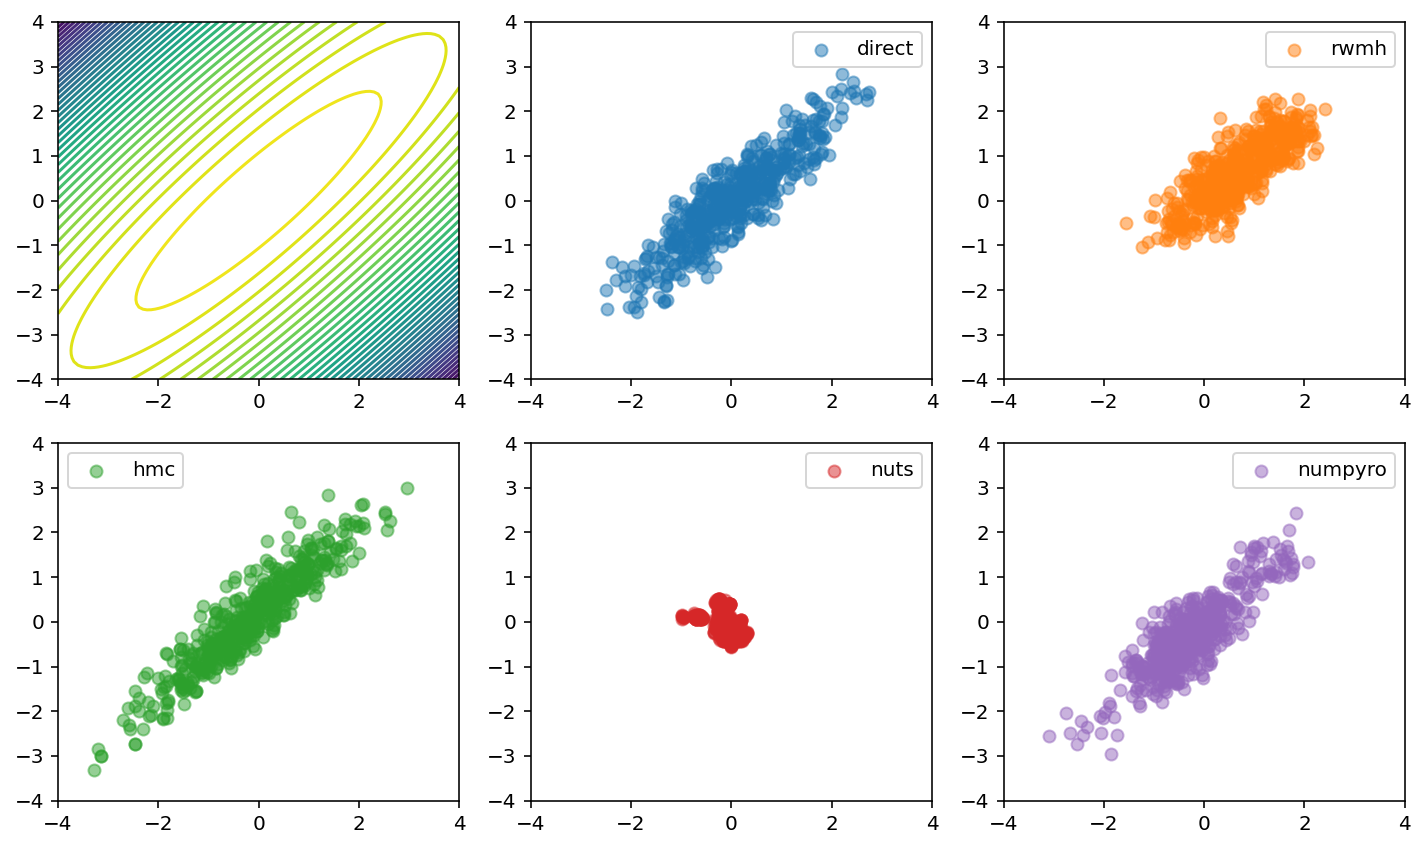

In [100]:
fig, axs = plt.subplots(2, 3, figsize=[10, 6])
axs = axs.flatten()
alpha = 0.5
r = 4

# plot PDF
grid_res = 100
x = jnp.linspace(-r, r, grid_res)
y = jnp.linspace(-r, r, grid_res)
x, y = jnp.meshgrid(x, y)
xy = jnp.stack([x.flatten(), y.flatten()], 1)
z = jax.scipy.stats.multivariate_normal.logpdf(xy, mean[:2], cov[:2, :2])
z = z.reshape(x.shape)
axs[0].contour(x, y, z, levels=50)

# plot sampled values
samples_dict = {
    'direct': direct_samples,
    'rwmh': chain_rwmh,
    'hmc': chain_hmc,
    'nuts': chain_nuts,
    'numpyro': chain_numpyro,
}
for i, (name, samples) in enumerate(samples_dict.items()):
    axs[i+1].scatter(samples[:, 0], samples[:, 1], alpha=alpha, label=name, c=f'C{i}')
    axs[i+1].set_xlim([-r, r])
    axs[i+1].set_ylim([-r, r])
    axs[i+1].legend()
    # axs[i+1].set_yticks([])
    # axs[i+1].set_xticks([])

plt.tight_layout()
plt.show()